# Preliminary

The exercise is as follows:

Imagine you are working as a mathematician/accountant at an cyber security firm. You receive data on cyber events of the last five years. This data includes information about the type of  incident, the industry of the company involved,, the size of the company, the geographical location, the duration of the incident and the
the cost of rectifying the incident.
Please develop a model to determine the risk premium for cyber risks. To develop and optimise
this model, please use machine learning algorithms. Please prepare a presentation of no more than 10 minutes in which you present your approach. You can present your results in the form of a PowerPoint presentation, in a Word document or just on a soundtrack, is up to you.
Important: There is no right or wrong. You should also be prepared to answer questions.

# Main idea
In order to solve this exercise, we create a hypothetical data set. Then, we train a machine learning model on this data learning the pattern regarding the costs. To conclude, we write a function that forecasts the net risk premium for a given entity considering potential uncertainty.
We don't calculate general premiums as available for example glasses security but rather individual premiums as cyber crime is relatively new and bears many unknowns.
In general, we make same assumptions to the data in order to handle computation time:

*   We assume that all firms are already registered for the last five years

*   There are only two types of location: East and West Germany
* There are only three types of cases: hacker attacks, data breaches and others
* There are only three sectors: Primary, Secondary, Tertiary
* A case is closed within 72 hours
* Firms have no more than 10,000 employees
* Each firm has at least one case to report, i.e., there are no firms without no case in the last five years

# Generating data
We assume the following relationship:

$$cost_{i,j} = 2 * employees_i + 5000 * secondary_i + 10000 * tertiary_i + 1000 * east_i + 100 * duration_{i,j} + 20000 * hacker_{i,j} + 50000 * databreach_{i,j} + \epsilon_{i,j} $$

with $j$ representing the case number per firm $i$. Costs are in Euro. $employees_i$ represents the number of employees in firm $i$, $secondary_i$ and $tertiary_i$ are dummies that are 1 of firm $i$ is primarily working in the second or third economical sector with the primary sector being the default. $duration_{i,j}$ is the duration of case $j$ for firm $i$ in hours. $hacker_{i,j}$ and $databreach_{i,j}$ are dummies indicating the type of case $j$ for firm $i$ with other cases being the default. In addition, there is an random error that changes the costs between one tenth less or one tenth more.

### Generating firm data

In [ ]:
# Set seed
set.seed(176)

# Generate random firms
num_firms = 1000

# Generate number of employees
employees = sample(1:10000, num_firms, replace = T)

# Generate dummy variable for East Germany
east_germany = sample(c(0, 1), num_firms, replace = TRUE)

# Generate random sector for each firm (primary, secondary, tertiary)
sectors = sample(c("Primary", "Secondary", "Tertiary"), num_firms, replace = TRUE)

# Generate number of cases for each firm
num_cases = sample(1:10, num_firms, replace = T)

# Create dataframe
firms = data.frame(
  firm_id = 1:num_firms,
  employees = employees,
  east = east_germany,
  sector = sectors,
  num_cases = num_cases
)

# Make dummies for sector
firms$secondary = ifelse(firms$sector == "Secondary", 1, 0)
firms$tertiary = ifelse(firms$sector == "Tertiary", 1, 0)
firms$sector = NULL

# Show data
head(firms)

,firm_id,employees,east,num_cases,secondary,tertiary
,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1,4330,0,2,0,1
2,2,4053,1,9,0,0
3,3,369,1,7,0,1
4,4,4908,1,1,0,0
5,5,2126,0,4,1,0
6,6,2009,0,2,0,1


### Generating cases

In [ ]:
# Set seed
set.seed(176)

# Replicate observations between 1 to 10 times
panel_data = firms[rep(row.names(firms), firms$num_cases), ]

# Reset row names
row.names(panel_data) = NULL

# Remove column num_cases
panel_data$num_cases = NULL

# Generate year number
panel_data$year = sample(2019:2023, nrow(panel_data), replace = TRUE)

# Generate random duration between 1 and 72 hours
panel_data$duration = sample(1:72, nrow(panel_data), replace = TRUE)

# Generate random case types for each firm (hacker, databreach, other)
panel_data$case_types = sample(c("Hacker", "Data Breach", "Other"), nrow(panel_data), replace = TRUE)
panel_data$hacker = ifelse(panel_data$case_types == "Hacker", 1, 0)
panel_data$databreach = ifelse(panel_data$case_types == "Data Breach", 1, 0)
panel_data$case_types = NULL

# Calculate costs based on the provided formula
panel_data$costs = 2 * panel_data$employees +
         5000 * panel_data$secondary +
         10000 * panel_data$tertiary +
         1000 * panel_data$east +
         100 * panel_data$duration  +
         20000 * panel_data$hacker +
         50000 * panel_data$databreach

# Add random error
panel_data$random_error = runif(nrow(panel_data), min = -0.1, max = 0.1)
panel_data$costs = round(panel_data$costs + (panel_data$costs * panel_data$random_error))
panel_data$random_error = NULL

# Show data
print(paste0("The panel data set has ", nrow(panel_data), " rows."))
head(panel_data, 20)

[1] "The panel data set has 5453 rows."


,firm_id,employees,east,secondary,tertiary,year,duration,hacker,databreach,costs
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,4330,0,0,1,2020,17,0,1,75011
2,1,4330,0,0,1,2023,56,0,0,24437
3,2,4053,1,0,0,2019,35,1,0,33630
4,2,4053,1,0,0,2022,31,0,1,57962
5,2,4053,1,0,0,2023,50,1,0,33822
6,2,4053,1,0,0,2019,54,0,1,61468
7,2,4053,1,0,0,2020,42,0,1,58373
8,2,4053,1,0,0,2019,13,0,0,9445
9,2,4053,1,0,0,2020,19,1,0,33834


# Analyze data

In [ ]:
print("Summary of firms")
summary(firms)
print("Summary of cases")
summary(panel_data)

[1] "Summary of firms"


    firm_id         employees         east         num_cases     
 Min.   :   1.0   Min.   :   4   Min.   :0.000   Min.   : 1.000  
 1st Qu.: 250.8   1st Qu.:2276   1st Qu.:0.000   1st Qu.: 3.000  
 Median : 500.5   Median :4763   Median :0.000   Median : 5.000  
 Mean   : 500.5   Mean   :4903   Mean   :0.492   Mean   : 5.453  
 3rd Qu.: 750.2   3rd Qu.:7421   3rd Qu.:1.000   3rd Qu.: 8.000  
 Max.   :1000.0   Max.   :9998   Max.   :1.000   Max.   :10.000  
   secondary       tertiary    
 Min.   :0.00   Min.   :0.000  
 1st Qu.:0.00   1st Qu.:0.000  
 Median :0.00   Median :0.000  
 Mean   :0.31   Mean   :0.337  
 3rd Qu.:1.00   3rd Qu.:1.000  
 Max.   :1.00   Max.   :1.000  

[1] "Summary of cases"


    firm_id         employees         east         secondary     
 Min.   :   1.0   Min.   :   4   Min.   :0.000   Min.   :0.0000  
 1st Qu.: 249.0   1st Qu.:2198   1st Qu.:0.000   1st Qu.:0.0000  
 Median : 499.0   Median :4746   Median :1.000   Median :0.0000  
 Mean   : 498.3   Mean   :4920   Mean   :0.505   Mean   :0.3127  
 3rd Qu.: 752.0   3rd Qu.:7603   3rd Qu.:1.000   3rd Qu.:1.0000  
 Max.   :1000.0   Max.   :9998   Max.   :1.000   Max.   :1.0000  
    tertiary           year         duration         hacker      
 Min.   :0.0000   Min.   :2019   Min.   : 1.00   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:2020   1st Qu.:18.00   1st Qu.:0.0000  
 Median :0.0000   Median :2021   Median :36.00   Median :0.0000  
 Mean   :0.3361   Mean   :2021   Mean   :36.25   Mean   :0.3402  
 3rd Qu.:1.0000   3rd Qu.:2022   3rd Qu.:54.00   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :2023   Max.   :72.00   Max.   :1.0000  
   databreach         costs      
 Min.   :0.0000   Min.   :  874  
 1st Qu.

### Calculate costs per year per firm

In [ ]:
# Install packages and set library
packages = c("dplyr")
install.packages(setdiff(packages, rownames(installed.packages())))
library(dplyr)

# Calculate 5-year average
firms_avg_costs = panel_data %>% group_by(firm_id) %>% summarise(costs_per_year = sum(costs)/5)
firms_avg_costs = merge(firms_avg_costs, firms[,c("firm_id", "employees", "east", "secondary", "tertiary")])

# Show data
head(firms_avg_costs, 20)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,firm_id,costs_per_year,employees,east,secondary,tertiary
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,19889.6,4330,0,0,1
2,2,71495.6,4053,1,0,0
3,3,58081.6,369,1,0,1
4,4,12488.4,4908,1,0,0
5,5,13837.8,2126,0,1,0
6,6,7504.4,2009,0,0,1
7,7,35066.6,2930,0,0,1
8,8,31868.8,2631,1,0,0
9,9,93439.4,9022,1,1,0


# Build model

### Preprocessing

In [ ]:
# Scale continuous variables
firms_avg_costs_scaled = firms_avg_costs
firms_avg_costs_scaled$costs_per_year = scale(firms_avg_costs$costs_per_year)
firms_avg_costs_scaled$employees = scale(firms_avg_costs$employees)

# Show data
nrow(firms_avg_costs_scaled)
head(firms_avg_costs_scaled, 20)

[1] 1000

,firm_id,costs_per_year,employees,east,secondary,tertiary
,<int>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>
1,1,-0.960709774,-0.196309878,0,0,1
2,2,0.898395334,-0.291134983,1,0,0
3,3,0.415156255,-1.552274655,1,0,1
4,4,-1.227337854,0.001556227,1,0,0
5,5,-1.178725747,-0.950802776,0,1,0
6,6,-1.406886354,-0.990855257,0,0,1
7,7,-0.413958655,-0.675570339,0,0,1
8,8,-0.529159336,-0.777926681,1,0,0
9,9,1.688920286,1.409897327,1,1,0


### Make train, validation and test split

In [ ]:
# Install packages and set library
packages = c("caTools", "neuralnet", "NeuralNetTools")
install.packages(setdiff(packages, rownames(installed.packages())))
library(caTools)
library(neuralnet)
library(NeuralNetTools)

# Split the dataset
set.seed(176)  # for reproducibility
split = sample.split(firms_avg_costs_scaled$costs_per_year, SplitRatio = 0.7)  # 70% train, 30% test
train_set = firms_avg_costs_scaled[split, ]
test_set = firms_avg_costs_scaled[!split, ]

# Further split the train set into train and validation sets
split2 = sample.split(train_set$costs_per_year, SplitRatio = 0.8)  # 80% train, 20% validation
validation_set = train_set[!split2, ]
train_set = train_set[split2, ]

# Print numbers
print(paste0("Number of rows in train set: ", nrow(train_set)))
print(paste0("Number of rows in validation set: ", nrow(validation_set)))
print(paste0("Number of rows in test set: ", nrow(test_set)))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’, ‘bitops’, ‘Deriv’, ‘reshape2’



Attaching package: ‘neuralnet’


The following object is masked from ‘package:dplyr’:

    compute




[1] "Number of rows in train set: 560"
[1] "Number of rows in validation set: 140"
[1] "Number of rows in test set: 300"


### Train model

In [ ]:
# Train a neural network model
model = neuralnet(costs_per_year ~ employees + east + secondary + tertiary, data = train_set, hidden = c(3), lifesign = "full", stepmax=1e7)

# Save the model
saveRDS(model, "neural_network_model.rds")

hidden: 3    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.0497288293257903
                                                
   1431
	error: 223.98149
	time: 0.38 secs



### Evaluate model
Here we could potentially compare more than one model.

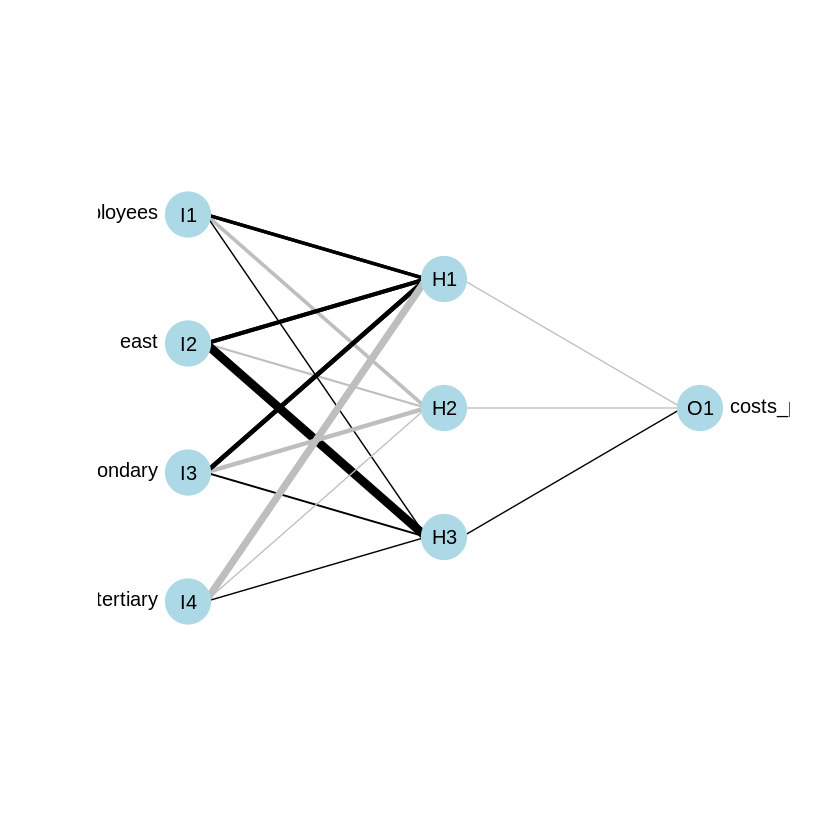

In [ ]:
# Plot model
plotnet(model, bias = FALSE)

In [ ]:
# Evaluate the model
predictions <- predict(model, test_set)
mse <- mean((predictions - test_set$costs_per_year)^2)  # Mean Squared Error
print(paste0("Mean Squared Error on test set: ", mse))

[1] "Mean Squared Error on test set: 1.09277591169724"


# Calculate uncertainty
Usually, neural networks and other non-parametric techniques such as Random Forest or SVM give point estimates instead of distributions. We use Monte-Carlo dropout to calculate uncertainty.

Cf. https://arxiv.org/abs/1506.02142 and https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction#:~:text=there%20are%20actually%20ways%20of%20doing%20this%20using%20dropout.%20

The package neuralnet is not really feasible to execute dropouts. Better suited would be keras but keras is more difficult to implement and has no nice visualization tools. Hence, we stick with neuralnet and do not really perform a dropout for this exercise. The uncertainty might already be calculable using different training runs.

In [ ]:
# Assess uncertainty without Monte-Carlo dropout
set.seed(176)
num_dropout_samples = 10  # Number of dropout samples

predictions_mc = matrix(NA, nrow = nrow(test_set), ncol = num_dropout_samples)
for (i in 1:num_dropout_samples) {
  # Disable dropout during prediction
  model_mc = neuralnet(costs_per_year ~ employees + east + secondary + tertiary, data = train_set, hidden = c(3), lifesign = "full", stepmax=1e7)
  predictions_mc[, i] = predict(model_mc, test_set)
}

# Calculate variance across predictions
variance = apply(predictions_mc, 1, var)
uncertainty = sqrt(variance)

hidden: 3    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.153128308108012
                                                
   2000	min thresh: 0.103224389629618
                                                
   3000	min thresh: 0.031107132541262
                                                
   4000	min thresh: 0.0145138907880522
                                                
   5000	min thresh: 0.0145138907880522
                                                
   6000	min thresh: 0.0145138907880522
                                                
   7000	min thresh: 0.0145138907880522
                                                
   8000	min thresh: 0.0145138907880522
                                                
   9000	min thresh: 0.0145138907880522
                                                
  10000	min thresh: 0.0145138907880522
                                                
  11000	min thresh: 0.0145138907880522
                                   

In [ ]:
head(uncertainty)
length(uncertainty)

[1] 0.18588406 0.14323473 0.10560240 0.11814343 0.07157789 0.12496050

[1] 300

# Calculate premium
We have to scale the inputs and rescale the output as the model is trained on normalized data.

In [ ]:
# Generate test data (USER INPUT)
new_data <- data.frame(
  employees = 3000,
  east = 0,
  secondary = 1,
  tertiary = 0
)

# Create function for calculating premiums
calculate_premium = function(nn_model, data_to_predict) {
  # scale employees
  data_to_predict$employees = (data_to_predict$employees - mean(firms_avg_costs$employees)) / sd(firms_avg_costs$employees)
  # make prediction
  predicted_value = neuralnet::compute(nn_model, data_to_predict)$net.result
  # rescale prediction
  rescaled_value = (predicted_value * sd(firms_avg_costs$costs_per_year)) + mean(firms_avg_costs$costs_per_year)
  return(rescaled_value)
}

# Test function
premium = calculate_premium(model, new_data)
print(paste0("A firm with the given data should pay a net premium of ",
      format(round(premium, 2), big.mark = ",", scientific = FALSE), " € per year without considering uncertainty."))
print(paste0("Adding a risk premium - assuming normality - the client should pay ",
      format(round(premium + 2*((mean(uncertainty) * sd(firms_avg_costs$costs_per_year)) + mean(firms_avg_costs$costs_per_year)), 2), big.mark = ",", scientific = FALSE),
      " € per year to cover a 95 % risk. Note, that this might be high in this proof of concept as we only sampled few times."))

[1] "A firm with the given data should pay a net premium of 34,572.64 € per year without considering uncertainty."
[1] "Adding a risk premium - assuming normality - the client should pay 135,172.4 € per year to cover a 95 % risk. Note, that this might be high in this proof of concept as we only sampled few times."
